# 2. Explainability of Random Forests

In [23]:
# Load the required packages

import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
import joblib

import matplotlib.pyplot as plt
import seaborn as sns
from utils import *  # Plots for the FI


import warnings
warnings.filterwarnings('ignore')

In [11]:
# Will delete that afterwards...
%load_ext autoreload
%autoreload 2
import fgclustering
from fgclustering import FgClustering
fgclustering.__file__

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


'/Users/helena.pelin/Desktop/Workmap/Projects/FGC/Code/fg-clustering-plotting/fgclustering/__init__.py'

We will load the dataset we were using for training (processed version) and the trained random forest model from the previous notebook:

In [12]:
# Load the data
data_penguins = pd.read_csv('./data/data_penguins_processed.csv', index_col=0)

# Separate the target and feature columns
X_penguins = data_penguins.loc[:, data_penguins.columns != 'species']
y_penguins = data_penguins.species

# Load the model
rf = joblib.load(open('./models/random_forest_penguins.joblib', 'rb'))

In [13]:
data_penguins.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,0,2,39.1,18.7,181.0,3750.0,1,2007
1,0,2,39.5,17.4,186.0,3800.0,0,2007
2,0,2,40.3,18.0,195.0,3250.0,0,2007
4,0,2,36.7,19.3,193.0,3450.0,0,2007
5,0,2,39.3,20.6,190.0,3650.0,1,2007


Remember, we were transforming our target variable into integeres with the LabelEncoder instance. The resulting mapping from that process looks like this:

- Adelie = 0
- Chinstrap = 1
- Gentoo = 2

<center><img src="./data/penguins.png" width='300'> </center>

## Feature importance

### Permutation feature importance

In the previous courses you were introduced to the Permutation feature importance. Now it is the time to see how it works on the real dataset. 


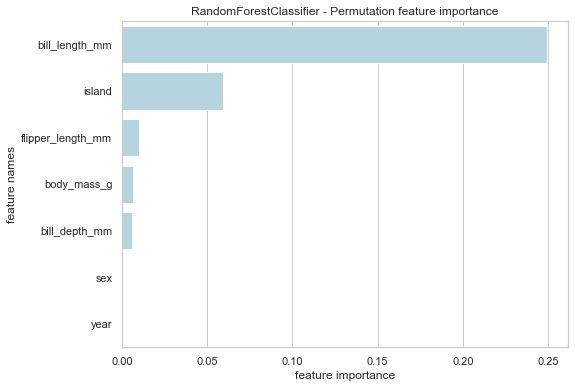

In [21]:
result = permutation_importance(rf, X_penguins, y_penguins, n_repeats=50, max_samples = 0.8, 
                                random_state=42)
plot_feature_importance(importance=result.importances_mean, names=X_penguins.columns, title="RandomForestClassifier - Permutation feature importance")

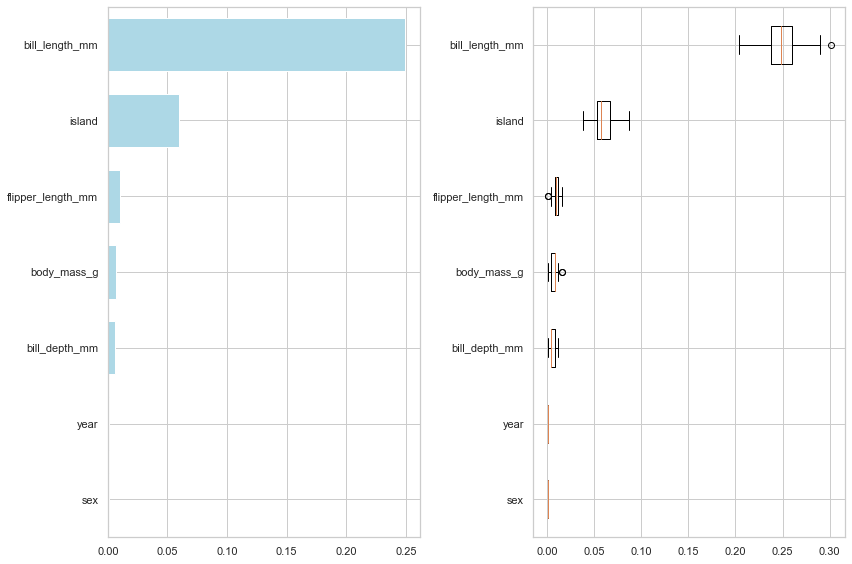

In [24]:
plot_perm_feature_importance(result, X_penguins)

### TASK 2.1
_____________
<font color='darkgreen'>
How big is the influence of the most important feature on the model performance?


Your answer here:

Permutation of the 'bill_length_mm' drops the accuracy by at most 0.3 (right plot), and on average 0.25 (left plot).
 
_____________

### Random Forest feature importance (impurity-based)


Feature importances are provided by the fitted attribute _feature_importances__ and they are computed as the mean and standard deviation of accumulation of the impurity decrease within each tree.

Lets plot the feature importance based on impurity:

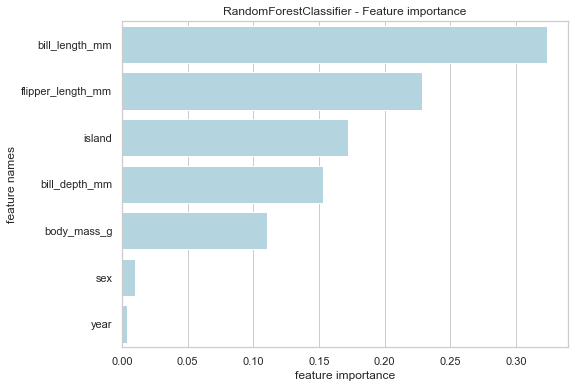

In [25]:
plot_feature_importance(rf.feature_importances_, names=X_penguins.columns, title="RandomForestClassifier - Feature importance")

### TASK 2.2
_____________
<font color='darkgreen'>
Inspect the differences between the results of the two feature importance plots. What do you notice? \
_Hint:_ Take a look at the correlation plot below



Your answer here:

First, it seems that random forest permutation importance identifies more important features than the permutation feature importance. Second, it seems like the feature importance of the correlated features flipper length and body mass are artificially lower due to the high correlation. Random forest feature importance does not seem to be affected by this correlation effect. This shows that permutation feature improtance results should be interpreted with great care in the presence of correlated features. 

_____________

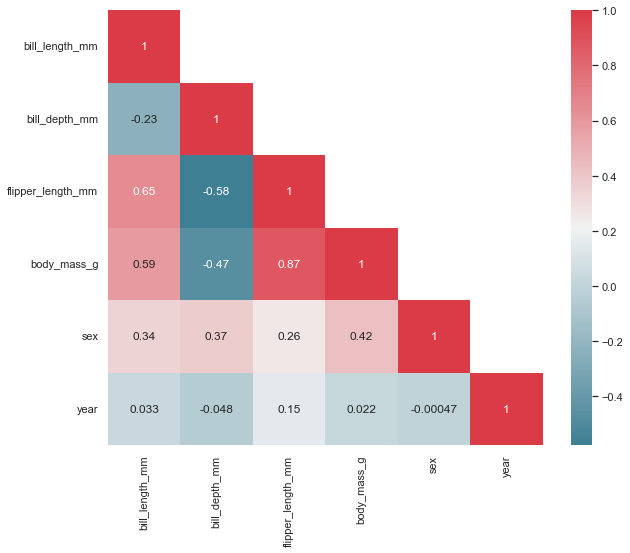

In [35]:
plot_correlation_matrix(X_penguins)

Even though the Random forest feature importance does overcome some dissadvantages of permutation feature importance, it does not give us more information about the class-specific differences and further insights into the decision making process of the random forest model. Therefore, we developed a model-specific interpretability method callsed Forest-Guided Clustering which we will now dive into. 

## Forest-Guided Clustering

**VIDEO (presentation with voice over)**

- algorithm overview on FGC -> figure

Documentation for the FGC: https://forest-guided-clustering.readthedocs.io/en/latest/

### FGC Example - explainability for Random Forest models

We will use FGC to gain more insights into decision paths of the random forest model we trained in the previous notebook. Afterwards, we will compare the results of the feature importance obtained by the previous methods and with FGC.

In [27]:
#  create an FGC instance
fgc = FgClustering(model=rf, data=X_penguins, target_column=y_penguins)

Interpreting RandomForestClassifier


FGC is based on K-Medoids clustering algorithm which requires a predefined number of clusters to be given. FGC is able to optimize the number of clusters based on the scoring function which is minimizing the model bias while restricting the model complexity. The argument _number_of_clusters_ is used to either pass the predefined cluster number or should be left empty if optimization is desired. 

For the sake of example and since the optimization part takes some time, we will stick to the given cluster number equal to the number of species present in the penguins dataset.

In [28]:
# Run the fgc instance:
fgc.run(number_of_clusters=3)

Use 3 as number of cluster


FGC provides couple of ways to visualise the results and help interpret them:

- visualise global and local feature importance - features that show different and concise value distributions across clusters are defined to be globally or locally important
- reveal the decision rules of RF model by visualizing feature patterns per cluster



### Feature importance from FGC - local and global

**Global feature importance** is represetned as the significance of the difference between cluster-wise feature distributions as a measure of global feature importance (ANOVA for continuous features and chi square for categorical features). **Features, which have significantly different distributions across clusters, have a high feature importance**, while features, which have a similar feature distribution across clusters have a low feature importance.

In addition to the global feature importance, we also provide a **local feature importance**, which gives the **importance of each feature for each cluster**. For the local feature importance we pre-filter the features based on the global feature importance (_thr_pvalue_ is used for the filtering step, just as in the plots before). Here, a feature is considered important if its distribution in a particlular cluster is clearly different from the feature distribution in the whole dataset.

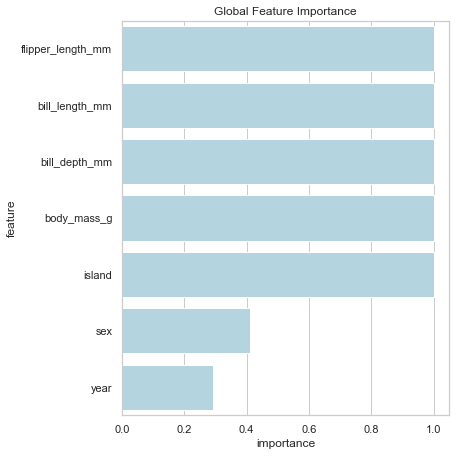

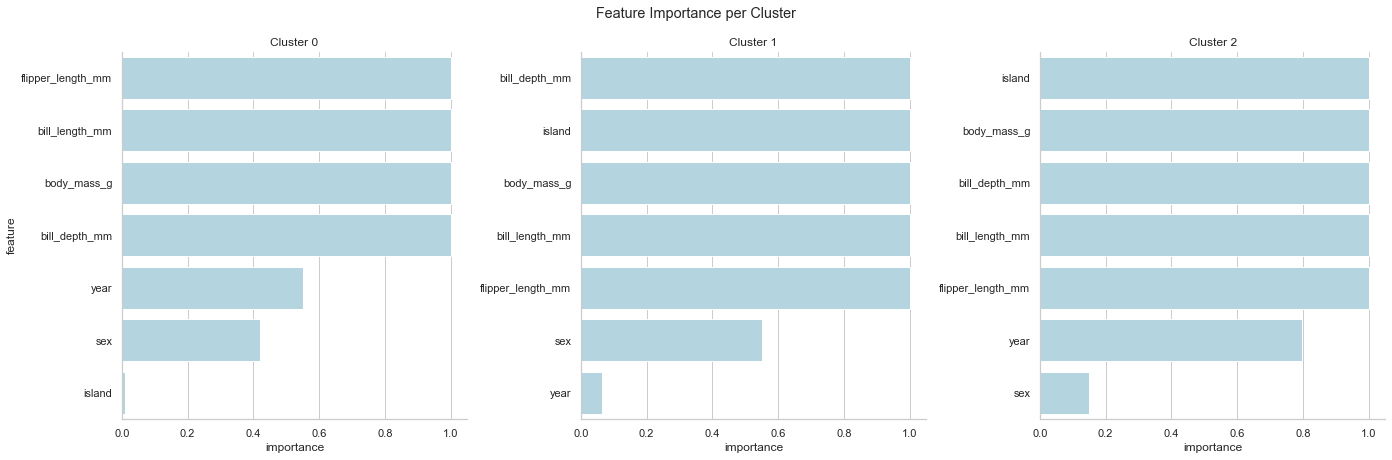

In [29]:
%matplotlib inline
# Plot global feature importance
fgc.plot_global_feature_importance()
# Plot local feature importance
fgc.plot_local_feature_importance(thr_pvalue=1) # We want to see all the features


### TASK 2.3
_____________
<font color='darkgreen'>
What do you observe when comparing the random forest based feature importance and the fgc feature importance?


Your answer here:

The global feature importance gives us the same results as the random forest feature importance. The local feature importance reveals more information. For example, the feature island is important for the cluster 1 and 2, but not for the cluster 0.

_____________


Forest-Guided Clustering provides the special option to visualize the decision path of a Random Forest model, reflecting the decision making process of that model, in a heatmap summary plot and a feature-wise distribution plot:

- The heatmap provides a general overview on the target value attribution and feature enrichment / depletion per cluster.  

- The distribution plots contain the same information as the heatmap just presented in a different way. Here the features are not standardized and we can see the actual scale of each feature on the y axis. Furthermore, we get an idea of the distribution of feature values within each cluster, e.g. having a small or high within-cluster-variation. 

We can choose which features we want to plot by specifying the _p_-value threshold applied to the _p_-values of the features from the global feature importance calculation. The default threshold _thr_pvalue_ is set to 0.01. By selecting the lower p-value threshold, we only plot features that show high differences between cluster-wise feature distributions. 


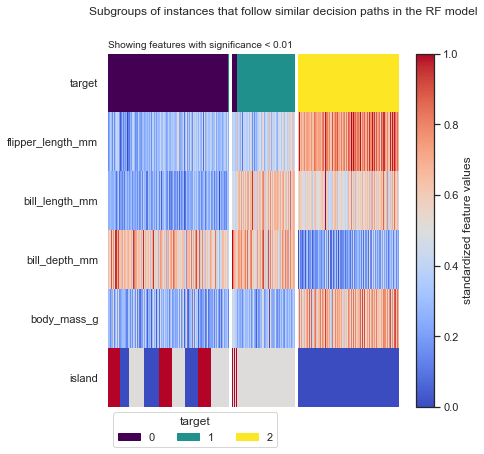

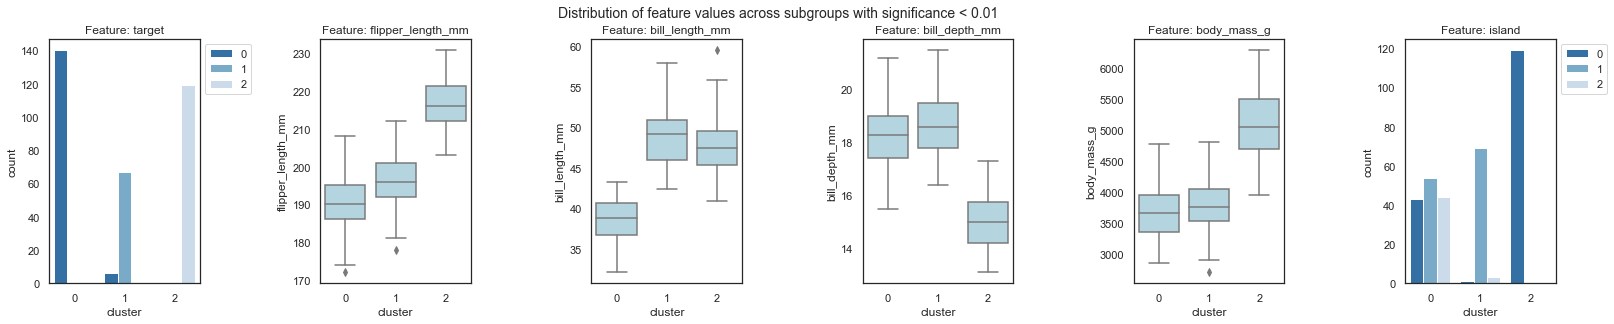

In [31]:
# Plot heatmap
fgc.plot_decision_paths(thr_pvalue=0.01) # feel free to try different p-values thresholds

### TASK 2.4
_______________________

By examining the plots created above, try to answer the following questions:

<font color=darkgreen>

1. Why are the features 'sex' and 'year' not shown on the plots above?
2. Try to describe species by observing the plots (Adelie = 0, Chinstrap = 1, Gentoo = 2). Use the following examples to guide you: 
    - What makes Gentoo different from the other two species? 
    - What makes Chinstrap different from Adelie?
    - ...


<img src='./data/bill_length.png' width='200'>

Your answer here:

1. We only show features with p-values < thr_pvalue = 0.01. This means that these two features don't show significant difference between clusters. Hence, they don't seem to play a role in the decision making process of this random forest model
2. For example, Gento has larger body mass and smaller bill depth. Adelie has smaller bill lenght.


_______________________